# Project 2: Reinforcement Learning agent to play Snake

Uncomment this code only if you want to use google colab

In [ ]:
# #use of google drive to import environment
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# import os
# os.chdir('/content/drive/MyDrive/AP_Assignement2')

In [ ]:
# !ls

## 2. Enhanced DQN with Experience Replay and Target Network

In [ ]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from snake_game import SnakeGame
from collections import namedtuple, deque
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Select the corresponding device
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [ ]:
# Define the hyperparameters
N_ACTIONS       = 3        # A = [left,forward,right] = [-1,0,1]
BOARD_SIZE      = 30       # Grid without boarder
BORDER          = 1        # Size of the boarder for each extremity
IN_CHANNELS     = 1        # Number of channels of the image (here we used rgb images but we actually use a grayscale version)
EPS_START       = 1.0      # Initial value of epsilon for the epsilon-greedy strategy
EPS_END         = 0.05     # Final value of epsiolon
EPS_DECAY       = 5000    # controls the rate of exponential decay of epsilon, higher means a slower decay
GAMMA           = 0.99     # Discount factor
LR              = 1e-4     # Learning rate
MAX_EPISODES = 10000        # Maximum number of episodes (doesn't include the episodes using heuristic)
PRETRAIN_EPISODES   = 500   # Maximum number of episodes using the heuristic function
MAX_STEPS       = 500     # Maximum number of steps within an episode
BATCH_SIZE = 64            # Number of transitions used for each training
BUFFER_CAPACITIES = [64,10000]    # Array of differents values for the buffer capacity

assert PRETRAIN_EPISODES <= MAX_EPISODES, "You can't have more pretrain episodes than the total number of episodes"
assert BATCH_SIZE <= min(BUFFER_CAPACITIES), "The maximum capacity of each buffer must be above the size of the batch"

In [ ]:
def preprocess(board):
    """
    Preprocess the board given by the function board_state(). It is a numpy array of shape (height,width,3).
    Therefore we want to transform this numpy image into a pytorch tensor of format [1,1,32,32] (1 batch, 1 channel,h,w)
    input: a frame corresponding to the current state of the game gird
    output: the preprocessed frame
    """
    gray = 0.2989 * board[:, :, 0] + 0.5870 * board[:, :, 1] + 0.1140 * board[:, :, 2]
    tensor = torch.from_numpy(gray).unsqueeze(0).unsqueeze(0)
    return tensor.to(torch.float32).to(device)

### 2.1 Experience Replay Buffer Implementation

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        # Add experience to buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # Random sampling of experiences
        experiences = random.sample(self.buffer, min(batch_size, len(self.buffer)))

        # Separate the tuple into batches
        states, actions, rewards, next_states, dones = zip(*experiences)

        return (
            torch.stack(states),
            torch.stack(actions),
            torch.stack(rewards),
            torch.stack(next_states),
            torch.stack(dones),
        )

    def __len__(self):
        return len(self.buffer)

In [ ]:
# Here we use a CNN model that will take as an input a preprocessed frame of the grid of the game
# And will provide as an output the Q-values for each possible actions
# Reminder: Conv2D(in_channels,out_channels,kernel_size,stride)
#
class DQN(nn.Module):
    def __init__(self, input_channels=IN_CHANNELS, num_actions=N_ACTIONS):
        super(DQN,self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.conv3 = nn.Conv2d(32, 32, 2, 1)

        def conv2d_size(size, kernel_size, stride):
            return (size - kernel_size) // stride + 1
        h = BOARD_SIZE
        h = conv2d_size(h, 5, 2)
        h = conv2d_size(h, 4, 2)
        h = conv2d_size(h, 2, 1)
        linear_input_size = 32 * h * h

        self.fc1   = nn.Linear(linear_input_size, 512)
        self.fc2   = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # x is still a 4D tensor at that point, therefore we need to flatten it before fc1
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

policy_net = DQN()
policy_net = policy_net.to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

In [ ]:
# Define the batch
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward', 'done'))

In [ ]:
def Q_learning_loss(policy_net, batch):
    """
    Loss function that computes the difference between the predicted Q-values and the target Q-values.
    Input: policy_net: model taking the images of the grid and computing the action to take
            batch: transion with the state, next_state, action and reward
    Output: Return the loss in a format of a scalar
    """
    # Q(s,a)
    q_pred = policy_net(batch.state).gather(1, batch.action)

    with torch.no_grad():
        # max of a' on Q(s',a')
        q_next = policy_net(batch.next_state).max(1, keepdim=True).values
        # r + GAMME * maxS(s',a')
        q_target = batch.reward + GAMMA * q_next

    mse = nn.MSELoss()
    # (r + GAMME * maxS(s',a') - Q(s,a))²
    return mse(q_target,q_pred)


In [ ]:
LEFT = -1
STRAIGHT = 0
RIGHT = 1
DIRS = {0:(-1,0), 1:(0,1), 2:(1,0), 3:(0,-1)}

def heuristic(state, height, width):
    """
    Heuristic based on the Manhattan distance. It will compute which direction to take in order to
    reduce the Manhattan distance and to avoid collisions with the border or itself
    Input: state: tuple containing the position of the head of the snake, the position of the apple,
    the direction of the snake and the postion of its tail
    Input: height: value of the height of the grid of the game
    Input: width: value of the width of the grid of the game
    Output: The action that the snake should take (i.e the direction to go to)
    """
    h_row,h_col = state[2] # Position of the head
    a_row,a_col = state[1][0] # Position of the first apple
    current_dir = state[4]
    tail_set = set(state[3]) # Position of each block of the snape except the head

    best_action = STRAIGHT
    best_dist = height*width # Initialize with a higher value than anything possible so that the first safe action is better
    safe_actions = []

    # Compute for every possible actions the new position of the head of the snake
    for action in (LEFT,STRAIGHT,RIGHT):
        direction = (current_dir + action) % 4
        mov_row, mov_col = DIRS[direction]
        new_h_row, new_h_col =  h_row + mov_row, h_col + mov_col

        if 0 <= new_h_row <= height and 0 <= new_h_col <= width: # Verify it doesn't collide with the border
            if not (new_h_row, new_h_col) in tail_set: # Verify it doesn't collide with its tail
                safe_actions.append(action)
                dist = abs(new_h_col - a_col) + abs(new_h_row - a_row)
                if dist < best_dist:
                    best_dist = dist
                    best_action = action

    return best_action

### 2.2 Integration with DQN Training

#### New training loop using the heuristic function

In [ ]:
env = SnakeGame(30,30,1)

def training_loop(memory):
    """
    Moved the training loop into a function to make it easier to execute it with differents memory replay
    buffer size.
    Input: memory: the replay memory buffer we are using
    Output: the scores, losses and apples eaten per episode
    """
    scores = []
    losses = []
    apples = []
    steps_done = 0

    for ep in range(1, MAX_EPISODES + 1):

        board, _, done, info = env.reset()
        state_img = preprocess(board)
        ep_ret = 0
        apples_ep = 0

        for t in range(MAX_STEPS):
            game_state = env.get_state()

            # Select the heuristic if we are in training mode
            if ep < PRETRAIN_EPISODES:
                action = heuristic(game_state, BOARD_SIZE+2*BORDER, BOARD_SIZE+2*BORDER)
                next_board, reward, done, info = env.step(action)
            # Else select the action based on the epsilon-greedy algorithm
            else:
                eps = EPS_END + (EPS_START - EPS_END) * math.exp(-steps_done / EPS_DECAY)
                q_values = policy_net(state_img)
                if torch.rand(1).item() < eps:
                    action_idx = torch.randint(0, N_ACTIONS, (1,), device=device)
                else:
                    action_idx = torch.argmax(q_values, dim=1)
                # Go from [0,1,2] to [-1,0,1]
                action = int(action_idx.item()) - 1
                next_board, reward, done, info = env.step(action)

            if reward > 0:
                apples_ep += 1

            next_state_img = preprocess(next_board)

            action_idx = torch.tensor([action + 1], device=device)
            reward_tensor = torch.tensor([reward], dtype=torch.float32, device=device)
            done_tensor = torch.tensor([float(done)], dtype=torch.float32, device=device)
            memory.add(
                state_img.squeeze(0),
                action_idx,
                next_state_img.squeeze(0),
                reward_tensor,
                done_tensor)

            # Eventough we verify the case in sample, waiting that we have enough batches in memory allow
            # a more stable training
            if len(memory) >= BATCH_SIZE and ep >= PRETRAIN_EPISODES:
                states, actions, next_states, rewards, dones = memory.sample(BATCH_SIZE)
                # print("states", states.shape)
                # print("actions", actions.shape)
                # print("rewards", rewards.shape)
                # print("next_states", next_states.shape)
                # print("dones", dones.shape)

                batch = Transition(states, actions, next_states, rewards, dones)
                loss = Q_learning_loss(policy_net, batch)
                optimizer.zero_grad(); loss.backward()
                nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()
                losses.append(loss.item())

            state_img = next_state_img
            ep_ret += reward
            if ep > PRETRAIN_EPISODES:
                steps_done += 1
            # Finish the episode if the snake died
            if done:
                break

        scores.append(ep_ret)
        apples.append(apples_ep)
        #losses.append(loss)
        if ep > PRETRAIN_EPISODES and ep % 100 == 0:
            avg_score = sum(scores[-100:]) / 100
            avg_loss  = sum(losses[-100*min(MAX_STEPS,100):]) / (100*min(MAX_STEPS,100))
            print(f"Episode: {ep}. Average score: {avg_score}. Loss: {avg_loss}. Epsilon: {eps}")
    return scores, losses, apples

In [ ]:
def plot_training_results(scores,losses,apples, window=100, pretrain_ep = PRETRAIN_EPISODES):
    """
    Plot scores and losses based on the provided data from the training loop
    Input: scores: the score of each episode
    Input: losses: the loss for each episode
    Input: apples: the number of apples eaten per episode
    Input: window: the window on each we compute the mean
    Input: pretrain_ep: the number of episode during which we use the heuristic function
    """
    avg_scores  = np.convolve(scores,  np.ones(window)/window, mode='valid')
    avg_apples  = np.convolve(apples, np.ones(window)/window, mode='valid')

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Score", color="tab:blue")
    ax1.plot(scores, alpha=0.5, label="score per episode")
    ax1.plot(np.arange(window-1, len(scores)), avg_scores, label=f"score moy. {window}")
    ax1.axvline(pretrain_ep, color='gray', label="End of pretraining")
    ax1.set_ylim(-2, 5)

    ax2 = ax1.twinx()
    ax2.set_ylabel("Apples / Episode.", color="tab:purple")
    ax2.plot(np.arange(window-1, len(apples)), avg_apples, color="tab:purple", label=f"Avg apples {window}")

    lines, labels = [], []
    for ax in fig.axes:
        for l in ax.get_lines():
            lines.append(l); labels.append(l.get_label())
    fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(0.01,0.99))

    plt.title("DQN Snake : score and apples eaten")
    plt.tight_layout()
    plt.show()

Episode: 600. Average score: -0.97. Loss: 0.01048705868756515. Epsilon: 0.6902520869078491
Episode: 700. Average score: -0.98. Loss: 0.05304513582604122. Epsilon: 0.49454975550976504
Episode: 800. Average score: -0.96. Loss: 0.07498545691033942. Epsilon: 0.36502814517452775
Episode: 900. Average score: -0.98. Loss: 0.09527733728790772. Epsilon: 0.2716860040712638
Episode: 1000. Average score: -0.98. Loss: 0.13614222001114976. Epsilon: 0.21217272721365343
Episode: 1100. Average score: -1.0. Loss: 0.1821087326024135. Epsilon: 0.17100864442751024
Episode: 1200. Average score: -0.98. Loss: 0.20776405950244517. Epsilon: 0.13801101565964274
Episode: 1300. Average score: -0.98. Loss: 0.21753990104943513. Epsilon: 0.11331118327739839
Episode: 1400. Average score: -0.99. Loss: 0.24023719584383071. Epsilon: 0.09890413653371119
Episode: 1500. Average score: -0.96. Loss: 0.2634539039464667. Epsilon: 0.08625081937866427
Episode: 1600. Average score: -0.97. Loss: 0.29517790777646. Epsilon: 0.0772993

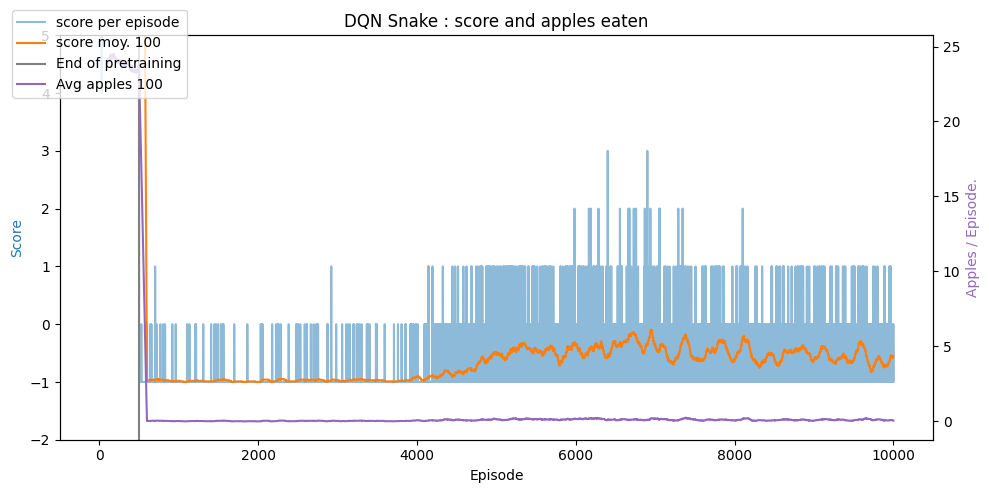

Episode: 600. Average score: -0.95. Loss: 0.01897092063772143. Epsilon: 0.6307160927071506
Episode: 700. Average score: -0.97. Loss: 0.047673291736101964. Epsilon: 0.2887607452413513
Episode: 800. Average score: -0.83. Loss: 0.025382857127307215. Epsilon: 0.0637310814834968
Episode: 900. Average score: -0.84. Loss: 0.004898589951291069. Epsilon: 0.05021685247065017
Episode: 1000. Average score: -0.68. Loss: 0.0038088204459672853. Epsilon: 0.05000142620527548
Episode: 1100. Average score: -0.78. Loss: 0.004215493742778199. Epsilon: 0.0500000165497756
Episode: 1200. Average score: -0.65. Loss: 0.004320493891955993. Epsilon: 0.050000000124951774
Episode: 1300. Average score: -0.44. Loss: 0.0011183996984776058. Epsilon: 0.050000000000170665
Episode: 1400. Average score: -0.6. Loss: 0.0035361817127217364. Epsilon: 0.05000000000000075
Episode: 1500. Average score: -0.55. Loss: 0.0033630480252017153. Epsilon: 0.05
Episode: 1600. Average score: -0.56. Loss: 0.0035103349390104995. Epsilon: 0.05

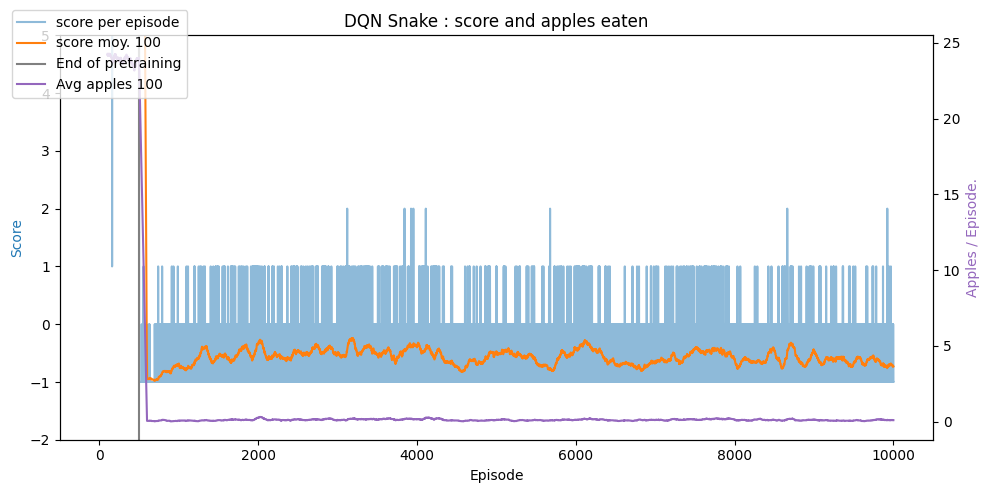

In [ ]:
for capacity in BUFFER_CAPACITIES:
    memory = ReplayBuffer(capacity)
    scores, losses, apples = training_loop(memory)
    plot_training_results(scores, losses, apples)

### 2.3 Target Network Implementation

In [ ]:
# Create the target network as a deep copy of the policy network (Step: initialization)
policy_net = DQN()
policy_net = policy_net.to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict()) # Copy the weights from the policy network

<All keys matched successfully>

In [ ]:
# New loss function that uses a target network (Step: Target Q-Value Calculation)
def new_Q_learning_loss(policy_net, target_net, batch):
    """
    Loss function that computes the difference between the predicted Q-values and the target Q-values
    using a separate target network.
    Input: policy_net: model taking the images of the grid and computing the action to take
           target_net: target model to compute the stable target Q-values
           batch: transition with the state, next_state, action and reward
    Output: Return the loss in the format of a scalar
    """
    # Q(s,a)
    q_pred = policy_net(batch.state).gather(1, batch.action)

    with torch.no_grad():
        # max of a' on Q(s',a') using target_net
        q_next = target_net(batch.next_state).max(1, keepdim=True).values
        # r + GAMMA * max(Q(s',a')) only if not done
        q_target = batch.reward + (1.0 - batch.done) * GAMMA * q_next

    mse = nn.MSELoss()
    # (r + GAMMA * max(Q(s',a')) - Q(s,a))²
    return mse(q_target, q_pred)


In [ ]:
# Function to perform the soft update of the target network (in Step: Update Strategy)
def soft_update(target, source, tau):
    """
    Soft update of the target network parameters.
    Input: target: the target network
           source: the policy network
           tau: the interpolation factor (0 < tau < 1)
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        # target_weights = τ*online_weights + (1-τ)*target_weights
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)


In [ ]:
env = SnakeGame(30,30,1)

# Define the new training loop function using a Target Network and its update strategy (using Step: Update Strategy)
def new_training_loop(memory, capacity, target_net, update_strategy="hard", tau=0.01):
    """
    Training loop function that uses a target network to stabilize the training.
    Input: memory: the replay memory buffer we are using
           capacity: the capacity of the replay buffer
           target_net: the target network used for the Q-learning loss
           update_strategy: "hard" for hard update, "soft" for soft update
           tau: parameter only for soft update
    Output: the scores, losses and apples eaten per episode
    """
    scores = []
    losses = []
    apples = []
    steps_done = 0

    for ep in range(1, MAX_EPISODES + 1):

        board, _, done, info = env.reset()
        state_img = preprocess(board)
        ep_ret = 0
        apples_ep = 0

        for t in range(MAX_STEPS):
            game_state = env.get_state()

            # Select the heuristic if we are in training mode
            if ep < PRETRAIN_EPISODES:
                action = heuristic(game_state, BOARD_SIZE+2*BORDER, BOARD_SIZE+2*BORDER)
                next_board, reward, done, info = env.step(action)
            # Else select the action based on the epsilon-greedy algorithm
            else:
                eps = EPS_END + (EPS_START - EPS_END) * math.exp(-steps_done / EPS_DECAY)
                q_values = policy_net(state_img)
                if torch.rand(1).item() < eps:
                    action_idx = torch.randint(0, N_ACTIONS, (1,), device=device)
                else:
                    action_idx = torch.argmax(q_values, dim=1)
                # Go from [0,1,2] to [-1,0,1]
                action = int(action_idx.item()) - 1
                next_board, reward, done, info = env.step(action)

            if reward > 0:
                apples_ep += 1

            next_state_img = preprocess(next_board)

            action_idx = torch.tensor([action + 1], device=device)
            reward_tensor = torch.tensor([[reward]], dtype=torch.float32, device=device)
            done_tensor = torch.tensor([[float(done)]], dtype=torch.float32, device=device)
            memory.add(
                state_img.squeeze(0),
                action_idx,
                next_state_img.squeeze(0),
                reward_tensor,
                done_tensor)

            # Eventough we verify the case in sample, waiting that we have enough batches in memory allow
            # a more stable training
            if len(memory) >= BATCH_SIZE and ep >= PRETRAIN_EPISODES:
                states, actions, next_states, rewards, dones = memory.sample(BATCH_SIZE)
                # print("states", states.shape)
                # print("actions", actions.shape)
                # print("rewards", rewards.shape)
                # print("next_states", next_states.shape)
                # print("dones", dones.shape)

                batch = Transition(states, actions, next_states, rewards, dones)
                loss = new_Q_learning_loss(policy_net, target_net, batch)
                optimizer.zero_grad(); loss.backward()
                nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()
                losses.append(loss.item())

            # Update target network every 100 steps using hard or soft update
            if steps_done % 100 == 0:
                if update_strategy == "hard":
                    target_net.load_state_dict(policy_net.state_dict())
                elif update_strategy == "soft":
                    soft_update(target_net, policy_net, tau)

            state_img = next_state_img
            ep_ret += reward
            if ep > PRETRAIN_EPISODES:
                steps_done += 1
            # Finish the episode if the snake died
            if done:
                break

        scores.append(ep_ret)
        apples.append(apples_ep)

        if ep > PRETRAIN_EPISODES and ep % 100 == 0:
            avg_score = sum(scores[-100:]) / 100
            avg_loss  = sum(losses[-100*min(MAX_STEPS,100):]) / (100*min(MAX_STEPS,100))
            print(f"Episode: {ep}. Average score: {avg_score}. Loss: {avg_loss}. Epsilon: {eps}")
    return scores, losses, apples


In [ ]:
def reset_weights(m):
    """
    Reset the weights of the model.
    Input: m: the model to reset
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()


Training with capacity of = 10000 and strategy = hard


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 600. Average score: -0.99. Loss: 0.009950176617295574. Epsilon: 0.7251007807851703
Episode: 700. Average score: -1.0. Loss: 0.024498631841386714. Epsilon: 0.5411069793414978
Episode: 800. Average score: -0.99. Loss: 0.038213926796213715. Epsilon: 0.4222858542521799
Episode: 900. Average score: -1.0. Loss: 0.05240871245912692. Epsilon: 0.31652338399933777
Episode: 1000. Average score: -0.99. Loss: 0.058694198973966535. Epsilon: 0.2653925084907717
Episode: 1100. Average score: -0.99. Loss: 0.062134023649652204. Epsilon: 0.23273956270810942
Episode: 1200. Average score: -1.0. Loss: 0.0644086804690676. Epsilon: 0.20132986408993003
Episode: 1300. Average score: -1.0. Loss: 0.06523552143027989. Epsilon: 0.18148095136623765
Episode: 1400. Average score: -1.0. Loss: 0.06211023148871848. Epsilon: 0.16219764287173208
Episode: 1500. Average score: -1.0. Loss: 0.058816046033132285. Epsilon: 0.1493910415743599
Episode: 1600. Average score: -1.0. Loss: 0.053627086288737906. Epsilon: 0.13594

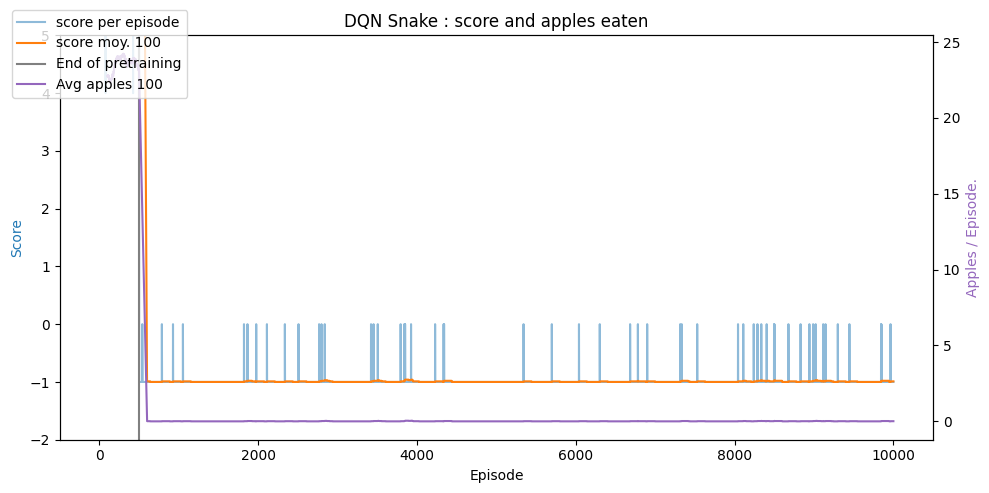

In [ ]:
import time

# Store the performance results for each buffer capacity
performance_results = {}
scores_history = {}
qvalues_history = {}

BUFFER_CAPACITIES = 10000 # The capacity giving the best results
capacity = BUFFER_CAPACITIES
STRATEGY = ["hard", "soft"]

# Training loop with target network and hard update
print(f"\nTraining with capacity of = {capacity} and strategy = {STRATEGY[0]}")

# Replay buffer with the specified capacity
memory = ReplayBuffer(capacity)

# Initialize the policy network and target network again
policy_net.apply(reset_weights)
target_net.load_state_dict(policy_net.state_dict())

# Training time measurement
start_time = time.time()

# Training loop with target network and soft update
scores, losses, apples = new_training_loop(memory, capacity, target_net, update_strategy="hard", tau=0.01)

# Stop time measurement
end_time = time.time()
training_time = end_time - start_time

# Compute final average score and loss
final_avg_score = np.mean(scores[-100:])
final_avg_loss = np.mean(losses[-100*min(MAX_STEPS,100):])

# Q-value mean estimation
avg_q_value = -final_avg_loss if final_avg_loss < 0 else final_avg_loss

# Store results for plotting
performance_results[capacity] = {
    "training_time": training_time,
    "avg_score": final_avg_score,
    "avg_q_value": avg_q_value,
    "score_per_time": final_avg_score / training_time,
    "qvalue_per_time": avg_q_value / training_time
}

# Store scores and Q-values history for plotting
scores_history[capacity] = scores
qvalues_history[capacity] = [-l if l < 0 else l for l in losses]

# Print the results
print(f"Training time: {training_time:.2f} secondes")
print(f"Average score: {final_avg_score:.2f}")
print(f"Q-value mean: {avg_q_value:.2f}")
print(f"Score / time: {final_avg_score/training_time:.4f}")
print(f"Q-value / time: {avg_q_value/training_time:.4f}")

# Display the training results
plot_training_results(scores, losses, apples)



Training with capacity of = 10000 and strategy = soft
Episode: 600. Average score: -0.99. Loss: 0.007765362549200654. Epsilon: 0.7430221662399418
Episode: 700. Average score: -1.0. Loss: 0.016833724270051607. Epsilon: 0.5443590052859226
Episode: 800. Average score: -0.99. Loss: 0.026259943436568234. Epsilon: 0.40462538706118933
Episode: 900. Average score: -0.98. Loss: 0.037640120253454756. Epsilon: 0.2905822398171214
Episode: 1000. Average score: -0.99. Loss: 0.04532961302852384. Epsilon: 0.2354271318382814
Episode: 1100. Average score: -0.98. Loss: 0.056356469852837134. Epsilon: 0.1808251873855326
Episode: 1200. Average score: -0.96. Loss: 0.05845140568332756. Epsilon: 0.14806808522061127
Episode: 1300. Average score: -0.98. Loss: 0.05953992338964638. Epsilon: 0.12923847565610022
Episode: 1400. Average score: -0.97. Loss: 0.06080191975967742. Epsilon: 0.11208236583439338
Episode: 1500. Average score: -0.99. Loss: 0.061889288890513226. Epsilon: 0.10128826556531666
Episode: 1600. Aver

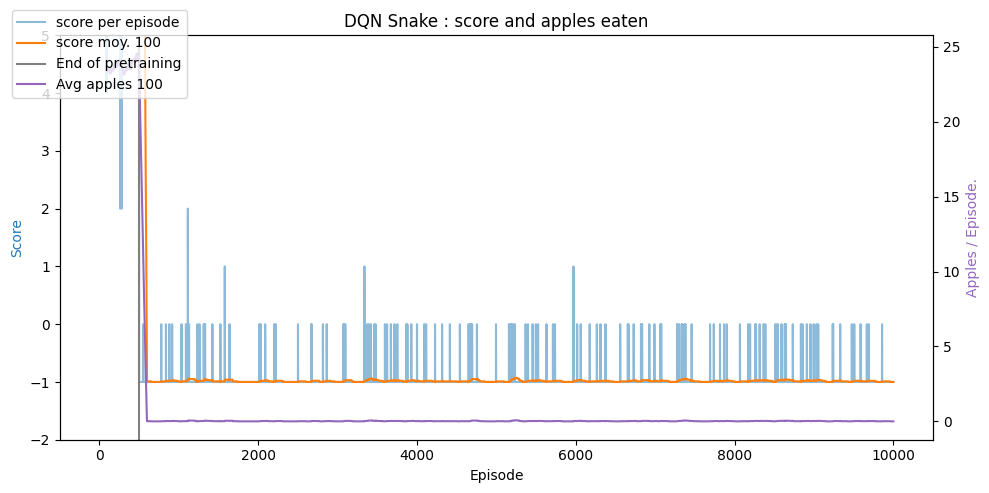

In [ ]:
import time

# Store the performance results for each buffer capacity
performance_results = {}
scores_history = {}
qvalues_history = {}

BUFFER_CAPACITIES = 10000 # The capacity giving the best results
capacity = BUFFER_CAPACITIES
STRATEGY = ["hard", "soft"]

# Training loop with target network and soft update

print(f"\nTraining with capacity of = {capacity} and strategy = {STRATEGY[1]}")

# Replay buffer with the specified capacity
memory = ReplayBuffer(capacity)

# Initialize the policy network and target network again
policy_net.apply(reset_weights)
target_net.load_state_dict(policy_net.state_dict())

# Training time measurement
start_time = time.time()

# Training loop with target network and soft update
scores, losses, apples = new_training_loop(memory, capacity, target_net, update_strategy="soft", tau=0.01)

# Stop time measurement
end_time = time.time()
training_time = end_time - start_time

# Compute final average score and loss
final_avg_score = np.mean(scores[-100:])
final_avg_loss = np.mean(losses[-100*min(MAX_STEPS,100):])

# Q-value mean estimation
avg_q_value = -final_avg_loss if final_avg_loss < 0 else final_avg_loss

# Store results for plotting
performance_results[capacity] = {
    "training_time": training_time,
    "avg_score": final_avg_score,
    "avg_q_value": avg_q_value,
    "score_per_time": final_avg_score / training_time,
    "qvalue_per_time": avg_q_value / training_time
}

# Store scores and Q-values history for plotting
scores_history[capacity] = scores
qvalues_history[capacity] = [-l if l < 0 else l for l in losses]

# Print the results
print(f"Training time: {training_time:.2f} secondes")
print(f"Average score: {final_avg_score:.2f}")
print(f"Q-value mean: {avg_q_value:.2f}")
print(f"Score / time: {final_avg_score/training_time:.4f}")
print(f"Q-value / time: {avg_q_value/training_time:.4f}")

# Display the training results
plot_training_results(scores, losses, apples)


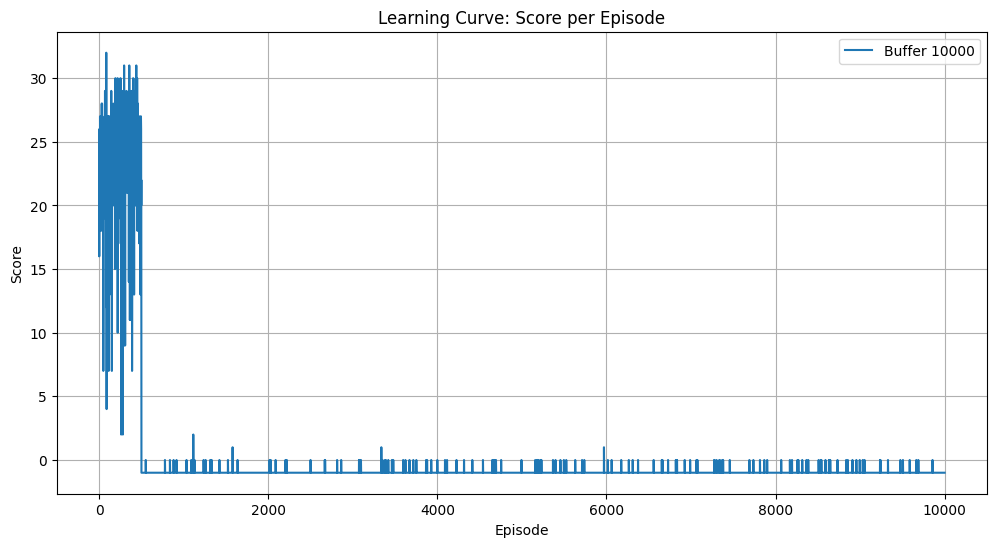

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(scores_history):
    plt.figure(figsize=(12, 6))
    for capacity, scores in scores_history.items():
        plt.plot(scores, label=f'Buffer {capacity}')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Learning Curve: Score per Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(scores_history)


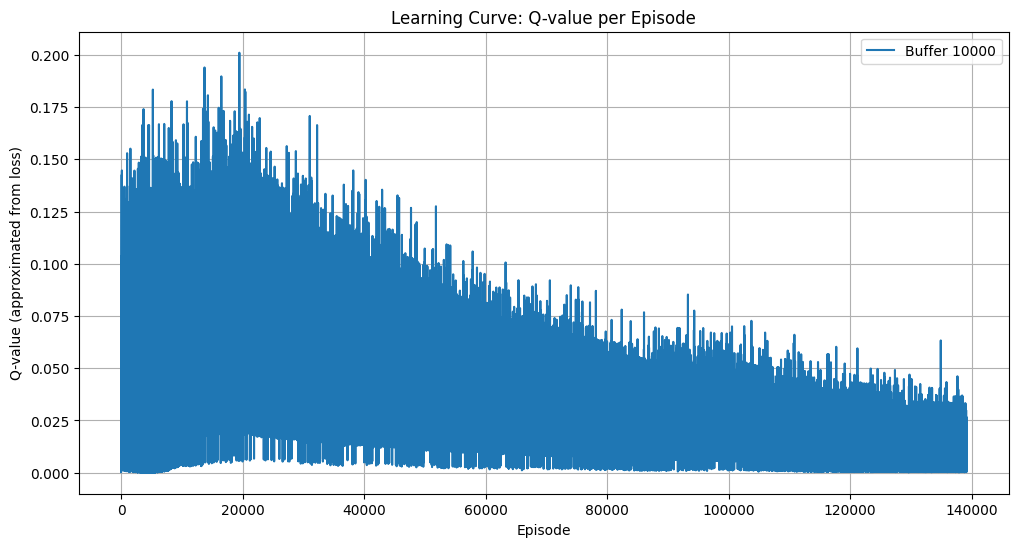

In [ ]:
def plot_qvalue_curves(qvalues_history):
    plt.figure(figsize=(12, 6))
    for capacity, qvalues in qvalues_history.items():
        plt.plot(qvalues, label=f'Buffer {capacity}')
    plt.xlabel('Episode')
    plt.ylabel('Q-value (approximated from loss)')
    plt.title('Learning Curve: Q-value per Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_qvalue_curves(qvalues_history)
